In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install nfp
!python -m pip install rdkit-pypi
!python -m pip install --upgrade rdkit-pypi pandas
!python -m pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!python -m pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 110.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 46.9 MB/s eta 0:00:00


## imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_scatter
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from datetime import datetime
import pytz

import wandb

from collections import Counter
from sklearn.linear_model import LinearRegression
import torch_scatter

import os
import numpy as np
from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)


#from nfp.preprocessing import MolPreprocessor, GraphSequence

import gzip
import pickle
import pandas as pd

# Define Keras model

import keras

from keras import (activations, initializers, regularizers, constraints)

import keras.backend as K

from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler

from keras.layers import (Input, Embedding, Dense, BatchNormalization, Dropout,
                                 Concatenate, Multiply, Add, Layer, Lambda)

from keras.models import Model, load_model

from keras.utils import Sequence

#from nfp.layers import (MessageLayer, GRUStep, Squeeze, EdgeNetwork,
 #                              ReduceAtomToMol, ReduceBondToAtom,
  #                             GatherAtomToBond, ReduceAtomToPro)
#from nfp.models import GraphModel
import argparse


from nfp.preprocessing import features
from nfp.preprocessing import Tokenizer
from tqdm import tqdm
import time


from rdkit import Chem

import tensorflow as tf
from random import shuffle

EST = 'US/Eastern'
tz = pytz.timezone(EST)

## CASCADE

In [ ]:
def atomic_number_tokenizer(atom):
    return atom.GetAtomicNum()
def Mol_iter(df):
    for index,r in df.iterrows():
        yield(r['Mol'], r['atom_index'])

class SmilesPreprocessor(object):
    """ Given a list of SMILES strings, encode these molecules as atom and
    connectivity feature matricies.

    Example:
    >>> preprocessor = SmilesPreprocessor(explicit_hs=False)
    >>> inputs = preprocessor.fit(data.smiles)
    """

    def __init__(self, explicit_hs=True, atom_features=None, bond_features=None):
        """

        explicit_hs : bool
            whether to tell RDkit to add H's to a molecule.
        atom_features : function
            A function applied to an rdkit.Atom that returns some
            representation (i.e., string, integer) for the Tokenizer class.
        bond_features : function
            A function applied to an rdkit Bond to return some description.

        """

        self.atom_tokenizer = Tokenizer()
        self.bond_tokenizer = Tokenizer()
        self.explicit_hs = explicit_hs

        if atom_features is None:
            atom_features = features.atom_features_v1

        if bond_features is None:
            bond_features = features.bond_features_v1

        self.atom_features = atom_features
        self.bond_features = bond_features


    def fit(self, smiles_iterator):
        """ Fit an iterator of SMILES strings, creating new atom and bond
        tokens for unseen molecules. Returns a dictionary with 'atom' and
        'connectivity' entries """
        return list(self.preprocess(smiles_iterator, train=True))


    def predict(self, smiles_iterator):
        """ Uses previously determined atom and bond tokens to convert a SMILES
        iterator into 'atom' and 'connectivity' matrices. Ensures that atom and
        bond classes commute with previously determined results. """
        return list(self.preprocess(smiles_iterator, train=False))


    def preprocess(self, smiles_iterator, train=True):

        self.atom_tokenizer.train = train
        self.bond_tokenizer.train = train

        for smiles in tqdm(smiles_iterator):
            yield self.construct_feature_matrices(smiles)


    @property
    def atom_classes(self):
        """ The number of atom types found (includes the 0 null-atom type) """
        return self.atom_tokenizer.num_classes + 1


    @property
    def bond_classes(self):
        """ The number of bond types found (includes the 0 null-bond type) """
        return self.bond_tokenizer.num_classes + 1


    def construct_feature_matrices(self, smiles):
        """ construct a molecule from the given smiles string and return atom
        and bond classes.

        Returns
        dict with entries
        'n_atom' : number of atoms in the molecule
        'n_bond' : number of bonds in the molecule
        'atom' : (n_atom,) length list of atom classes
        'bond' : (n_bond,) list of bond classes
        'connectivity' : (n_bond, 2) array of source atom, target atom pairs.

        """

        mol = MolFromSmiles(smiles)
        if self.explicit_hs:
            mol = AddHs(mol)

        n_atom = len(mol.GetAtoms())
        n_bond = 2 * len(mol.GetBonds())

        # If its an isolated atom, add a self-link
        if n_bond == 0:
            n_bond = 1

        atom_feature_matrix = np.zeros(n_atom, dtype='int')
        bond_feature_matrix = np.zeros(n_bond, dtype='int')
        connectivity = np.zeros((n_bond, 2), dtype='int')

        bond_index = 0

        atom_seq = mol.GetAtoms()
        atoms = [atom_seq[i] for i in range(n_atom)]

        for n, atom in enumerate(atoms):

            # Atom Classes
            atom_feature_matrix[n] = self.atom_tokenizer(
                self.atom_features(atom))

            start_index = atom.GetIdx()

            for bond in atom.GetBonds():
                # Is the bond pointing at the target atom
                rev = bond.GetBeginAtomIdx() != start_index

                # Bond Classes
                bond_feature_matrix[n] = self.bond_tokenizer(
                    self.bond_features(bond, flipped=rev))

                # Connectivity
                if not rev:  # Original direction
                    connectivity[bond_index, 0] = bond.GetBeginAtomIdx()
                    connectivity[bond_index, 1] = bond.GetEndAtomIdx()

                else:  # Reversed
                    connectivity[bond_index, 0] = bond.GetEndAtomIdx()
                    connectivity[bond_index, 1] = bond.GetBeginAtomIdx()

                bond_index += 1


        return {
            'n_atom': n_atom,
            'n_bond': n_bond,
            'atom': atom_feature_matrix,
            'bond': bond_feature_matrix,
            'connectivity': connectivity,
        }


class ConnectivityAPreprocessor(object):
    """ Given a list of SMILES strings, encode these molecules as atom and
    connectivity feature matricies.

    Example:
    >>> preprocessor = SmilesPreprocessor(explicit_hs=False)
    >>> inputs = preprocessor.fit(data.smiles)
    """

    def __init__(self, explicit_hs=True, atom_features=None, bond_features=None):
        """

        explicit_hs : bool
            whether to tell RDkit to add H's to a molecule.
        atom_features : function
            A function applied to an rdkit.Atom that returns some
            representation (i.e., string, integer) for the Tokenizer class.
        bond_features : function
            A function applied to an rdkit Bond to return some description.

        """

        self.atom_tokenizer = Tokenizer()
        self.bond_tokenizer = Tokenizer()
        self.explicit_hs = explicit_hs

        if atom_features is None:
            atom_features = features.atom_features_v1

        if bond_features is None:
            bond_features = features.bond_features_v1

        self.atom_features = atom_features
        self.bond_features = bond_features


    def fit(self, smiles_iterator):
        """ Fit an iterator of SMILES strings, creating new atom and bond
        tokens for unseen molecules. Returns a dictionary with 'atom' and
        'connectivity' entries """
        return list(self.preprocess(smiles_iterator, train=True))


    def predict(self, smiles_iterator):
        """ Uses previously determined atom and bond tokens to convert a SMILES
        iterator into 'atom' and 'connectivity' matrices. Ensures that atom and
        bond classes commute with previously determined results. """
        return list(self.preprocess(smiles_iterator, train=False))


    def preprocess(self, smiles_iterator, train=True):

        self.atom_tokenizer.train = train
        self.bond_tokenizer.train = train

        for smiles in tqdm(smiles_iterator):
            yield self.construct_feature_matrices(smiles)


    @property
    def atom_classes(self):
        """ The number of atom types found (includes the 0 null-atom type) """
        return self.atom_tokenizer.num_classes + 1


    @property
    def bond_classes(self):
        """ The number of bond types found (includes the 0 null-bond type) """
        return self.bond_tokenizer.num_classes + 1


    def construct_feature_matrices(self, smiles):
        """ construct a molecule from the given smiles string and return atom
        and bond classes.

        Returns
        dict with entries
        'n_atom' : number of atoms in the molecule
        'n_bond' : number of bonds in the molecule
        'atom' : (n_atom,) length list of atom classes
        'bond' : (n_bond,) list of bond classes
        'connectivity' : (n_bond, 2) array of source atom, target atom pairs.

        """

        mol = MolFromSmiles(smiles)
        if self.explicit_hs:
            mol = AddHs(mol)

        n_atom = len(mol.GetAtoms())
        n_bond = 2 * len(mol.GetBonds())

        # If its an isolated atom, add a self-link
        if n_bond == 0:
            n_bond = 1

        atom_feature_matrix = np.zeros(n_atom, dtype='int')
        bond_feature_matrix = np.zeros(n_bond, dtype='int')
        connectivity = np.zeros((n_bond, 2), dtype='int')

        bond_index = 0

        atom_seq = mol.GetAtoms()
        atoms = [atom_seq[i] for i in range(n_atom)]

        for n, atom in enumerate(atoms):

            # Atom Classes
            atom_feature_matrix[n] = self.atom_tokenizer(
                self.atom_features(atom))

            start_index = atom.GetIdx()

            for bond in atom.GetBonds():
                # Is the bond pointing at the target atom
                rev = bond.GetBeginAtomIdx() != start_index

                # Bond Classes
                bond_feature_matrix[n] = self.bond_tokenizer(
                    self.bond_features(bond, flipped=rev))

                # Connectivity
                if not rev:  # Original direction
                    connectivity[bond_index, 0] = bond.GetBeginAtomIdx()
                    connectivity[bond_index, 1] = bond.GetEndAtomIdx()

                else:  # Reversed
                    connectivity[bond_index, 0] = bond.GetEndAtomIdx()
                    connectivity[bond_index, 1] = bond.GetBeginAtomIdx()

                bond_index += 1

        return {
            'n_atom': n_atom,
            'n_bond': n_bond,
            'atom': atom_feature_matrix,
            'bond': bond_feature_matrix,
            'connectivity': connectivity,
        }


class MolPreprocessor(SmilesPreprocessor):
    """ I should refactor this into a base class and separate
    SmilesPreprocessor classes. But the idea is that we only need to redefine
    the `construct_feature_matrices` method to have a working preprocessor that
    handles 3D structures.

    We'll pass an iterator of mol objects instead of SMILES strings this time,
    though.

    """

    def __init__(self, n_neighbors, cutoff, **kwargs):
        """ A preprocessor class that also returns distances between
        neighboring atoms. Adds edges for non-bonded atoms to include a maximum
        of n_neighbors around each atom """

        self.n_neighbors = n_neighbors
        self.cutoff = cutoff
        super(MolPreprocessor, self).__init__(**kwargs)


    def construct_feature_matrices(self, mol):
        """ Given an rdkit mol, return atom feature matrices, bond feature
        matrices, and connectivity matrices.

        Returns
        dict with entries
        'n_atom' : number of atoms in the molecule
        'n_bond' : number of edges (likely n_atom * n_neighbors)
        'atom' : (n_atom,) length list of atom classes
        'bond' : (n_bond,) list of bond classes. 0 for no bond
        'distance' : (n_bond,) list of bond distances
        'connectivity' : (n_bond, 2) array of source atom, target atom pairs.

        """

        n_atom = len(mol.GetAtoms())

        # n_bond is actually the number of atom-atom pairs, so this is defined
        # by the number of neighbors for each atom.
        #if there is cutoff,
        distance_matrix = Chem.Get3DDistanceMatrix(mol)

        if self.n_neighbors <= (n_atom - 1):
            n_bond = self.n_neighbors * n_atom
        else:
            # If there are fewer atoms than n_neighbors, all atoms will be
            # connected
            n_bond = distance_matrix[(distance_matrix < self.cutoff) & (distance_matrix != 0)].size

        if n_bond == 0: n_bond = 1

        # Initialize the matrices to be filled in during the following loop.
        atom_feature_matrix = np.zeros(n_atom, dtype='int')
        bond_feature_matrix = np.zeros(n_bond, dtype='int')
        bond_distance_matrix = np.zeros(n_bond, dtype=np.float32)
        connectivity = np.zeros((n_bond, 2), dtype='int')

        # Hopefully we've filtered out all problem mols by now.
        if mol is None:
            raise RuntimeError("Issue in loading mol")

        # Get a list of the atoms in the molecule.
        atom_seq = mol.GetAtoms()
        atoms = [atom_seq[i] for i in range(n_atom)]

        # Here we loop over each atom, and the inner loop iterates over each
        # neighbor of the current atom.
        bond_index = 0  # keep track of our current bond.
        for n, atom in enumerate(atoms):

            # update atom feature matrix
            atom_feature_matrix[n] = self.atom_tokenizer(
                self.atom_features(atom))

            # if n_neighbors is greater than total atoms, then each atom is a
            # neighbor.
            if (self.n_neighbors + 1) > len(mol.GetAtoms()):
                neighbor_end_index = len(mol.GetAtoms())
            else:
                neighbor_end_index = (self.n_neighbors + 1)

            distance_atom = distance_matrix[n, :]
            cutoff_end_index = distance_atom[distance_atom < self.cutoff].size

            end_index = min(neighbor_end_index, cutoff_end_index)

            # Loop over each of the nearest neighbors

            neighbor_inds = distance_matrix[n, :].argsort()[1:end_index]
            if len(neighbor_inds)==0: neighbor_inds = [n]
            for neighbor in neighbor_inds:

                # update bond feature matrix
                bond = mol.GetBondBetweenAtoms(n, int(neighbor))
                if bond is None:
                    bond_feature_matrix[bond_index] = 0
                else:
                    rev = False if bond.GetBeginAtomIdx() == n else True
                    bond_feature_matrix[bond_index] = self.bond_tokenizer(
                        self.bond_features(bond, flipped=rev))

                distance = distance_matrix[n, neighbor]
                bond_distance_matrix[bond_index] = distance

                # update connectivity matrix
                connectivity[bond_index, 0] = n
                connectivity[bond_index, 1] = neighbor

                bond_index += 1
        print(connectivity)

        return {
            'n_atom': n_atom,
            'n_bond': n_bond,
            'atom': atom_feature_matrix,
            'bond': bond_feature_matrix,
            'distance': bond_distance_matrix,
            'connectivity': connectivity,
        }


class MolBPreprocessor(MolPreprocessor):
    """
    This is a subclass of Molpreprocessor that preprocessor molecule with
    bond property target
    """
    def __init__(self, **kwargs):
        """
        A preprocessor class that also returns bond_target_matrix, besides the bond matrix
        returned by MolPreprocessor. The bond_target_matrix is then used as ref to reduce molecule
        to bond property
        """
        super(MolBPreprocessor, self).__init__(**kwargs)

    def construct_feature_matrices(self, entry):
        """
        Given an entry contining rdkit molecule, bond_index and for the target property,
        return atom
        feature matrices, bond feature matrices, distance matrices, connectivity matrices and bond
        ref matrices.

        returns
        dict with entries
        see MolPreproccessor
        'bond_index' : ref array to the bond index
        """
        mol, bond_index_array = entry

        n_atom = len(mol.GetAtoms())
        n_pro = len(bond_index_array)

        # n_bond is actually the number of atom-atom pairs, so this is defined
        # by the number of neighbors for each atom.
        #if there is cutoff,
        distance_matrix = Chem.Get3DDistanceMatrix(mol)

        if self.n_neighbors <= (n_atom - 1):
            n_bond = self.n_neighbors * n_atom
        else:
            # If there are fewer atoms than n_neighbors, all atoms will be
            # connected
            n_bond = distance_matrix[(distance_matrix < self.cutoff) & (distance_matrix != 0)].size

        if n_bond == 0: n_bond = 1

        # Initialize the matrices to be filled in during the following loop.
        atom_feature_matrix = np.zeros(n_atom, dtype='int')
        bond_feature_matrix = np.zeros(n_bond, dtype='int')
        bond_distance_matrix = np.zeros(n_bond, dtype=np.float32)
        bond_index_matrix = np.full(n_bond, -1, dtype='int')
        connectivity = np.zeros((n_bond, 2), dtype='int')

        # Hopefully we've filtered out all problem mols by now.
        if mol is None:
            raise RuntimeError("Issue in loading mol")

        # Get a list of the atoms in the molecule.
        atom_seq = mol.GetAtoms()
        atoms = [atom_seq[i] for i in range(n_atom)]

        # Here we loop over each atom, and the inner loop iterates over each
        # neighbor of the current atom.
        bond_index = 0  # keep track of our current bond.
        for n, atom in enumerate(atoms):
            # update atom feature matrix
            atom_feature_matrix[n] = self.atom_tokenizer(
                self.atom_features(atom))

            # if n_neighbors is greater than total atoms, then each atom is a
            # neighbor.
            if (self.n_neighbors + 1) > len(mol.GetAtoms()):
                neighbor_end_index = len(mol.GetAtoms())
            else:
                neighbor_end_index = (self.n_neighbors + 1)

            distance_atom = distance_matrix[n, :]
            cutoff_end_index = distance_atom[distance_atom < self.cutoff].size

            end_index = min(neighbor_end_index, cutoff_end_index)

            # Loop over each of the nearest neighbors

            neighbor_inds = distance_matrix[n, :].argsort()[1:end_index]
            if len(neighbor_inds)==0: neighbor_inds = [n]
            for neighbor in neighbor_inds:

                # update bond feature matrix
                bond = mol.GetBondBetweenAtoms(n, int(neighbor))
                if bond is None:
                    bond_feature_matrix[bond_index] = 0
                else:
                    rev = False if bond.GetBeginAtomIdx() == n else True
                    bond_feature_matrix[bond_index] = self.bond_tokenizer(
                        self.bond_features(bond, flipped=rev))
                    try:
                        bond_index_matrix[bond_index] = bond_index_array.tolist().index(bond.GetIdx())
                    except:
                        pass

                distance = distance_matrix[n, neighbor]
                bond_distance_matrix[bond_index] = distance

                # update connectivity matrix
                connectivity[bond_index, 0] = n
                connectivity[bond_index, 1] = neighbor

                bond_index += 1
        return {
            'n_atom': n_atom,
            'n_bond': n_bond,
            'n_pro': n_pro,
            'atom': atom_feature_matrix,
            'bond': bond_feature_matrix,
            'distance': bond_distance_matrix,
            'connectivity': connectivity,
            'bond_index': bond_index_matrix,
        }

class MolAPreprocessor(MolPreprocessor):
    """
    This is a subclass of Molpreprocessor that preprocessor molecule with
    bond property target
    """
    def __init__(self, **kwargs):
        """
        A preprocessor class that also returns bond_target_matrix, besides the bond matrix
        returned by MolPreprocessor. The bond_target_matrix is then used as ref to reduce molecule
        to bond property
        """
        super(MolAPreprocessor, self).__init__(**kwargs)

    def construct_feature_matrices(self, entry):
        """
        Given an entry contining rdkit molecule, bond_index and for the target property,
        return atom
        feature matrices, bond feature matrices, distance matrices, connectivity matrices and bond
        ref matrices.

        returns
        dict with entries
        see MolPreproccessor
        'bond_index' : ref array to the bond index
        """
        mol, atom_index_array = entry

        n_atom = len(mol.GetAtoms())
        n_pro = len(atom_index_array)

        # n_bond is actually the number of atom-atom pairs, so this is defined
        # by the number of neighbors for each atom.
        #if there is cutoff,
        distance_matrix = Chem.Get3DDistanceMatrix(mol)

        #if self.n_neighbors <= (n_atom - 1):
        #    n_bond = self.n_neighbors * n_atom
        #else:
            # If there are fewer atoms than n_neighbors, all atoms will be
            # connected
        n_bond = distance_matrix[(distance_matrix < self.cutoff) & (distance_matrix != 0)].size

        if n_bond == 0: n_bond = 1

        # Initialize the matrices to be filled in during the following loop.
        atom_feature_matrix = np.zeros(n_atom, dtype='int')
        bond_feature_matrix = np.zeros(n_bond, dtype='int')
        bond_distance_matrix = np.zeros(n_bond, dtype=np.float32)
        atom_index_matrix = np.full(n_atom, -1, dtype='int')
        connectivity = np.zeros((n_bond, 2), dtype='int')

        # Hopefully we've filtered out all problem mols by now.
        if mol is None:
            raise RuntimeError("Issue in loading mol")

        # Get a list of the atoms in the molecule.
        atom_seq = mol.GetAtoms()
        atoms = [atom_seq[i] for i in range(n_atom)]

        # Here we loop over each atom, and the inner loop iterates over each
        # neighbor of the current atom.
        bond_index = 0  # keep track of our current bond.
        for n, atom in enumerate(atoms):
            # update atom feature matrix
            atom_feature_matrix[n] = self.atom_tokenizer(
                self.atom_features(atom))
            try:
                atom_index_matrix[n] = atom_index_array.tolist().index(atom.GetIdx())
            except:
                pass
            # if n_neighbors is greater than total atoms, then each atom is a
            # neighbor.
            if (self.n_neighbors + 1) > len(mol.GetAtoms()):
                neighbor_end_index = len(mol.GetAtoms())
            else:
                neighbor_end_index = (self.n_neighbors + 1)

            distance_atom = distance_matrix[n, :]
            cutoff_end_index = distance_atom[distance_atom < self.cutoff].size

            end_index = min(neighbor_end_index, cutoff_end_index)

            # Loop over each of the nearest neighbors

            neighbor_inds = distance_matrix[n, :].argsort()[1:end_index]
            if len(neighbor_inds)==0: neighbor_inds = [n]
            for neighbor in neighbor_inds:

                # update bond feature matrix
                bond = mol.GetBondBetweenAtoms(n, int(neighbor))
                try:
                    if bond is None:
                        bond_feature_matrix[bond_index] = 0
                    else:
                        rev = False if bond.GetBeginAtomIdx() == n else True
                        bond_feature_matrix[bond_index] = self.bond_tokenizer(
                            self.bond_features(bond, flipped=rev))
                except:
                    print('AAAAAAAAAAAAAAA')
                    print(mol.GetProp('_Name'))
                    print(mol.GetProp('ConfId'))

                distance = distance_matrix[n, neighbor]
                bond_distance_matrix[bond_index] = distance

                # update connectivity matrix
                connectivity[bond_index, 0] = n
                connectivity[bond_index, 1] = neighbor

                bond_index += 1
        return {
            'n_atom': n_atom,
            'n_bond': n_bond,
            'n_pro': n_pro,
            'atom': atom_feature_matrix,
            'bond': bond_feature_matrix,
            'distance': bond_distance_matrix,
            'connectivity': connectivity,
            'atom_index': atom_index_matrix,
        }



## Additional Functions

In [ ]:
def rbf_expansion(distances, mu=0, delta=0.1, kmax=256):
    k = np.arange(0, kmax)
    logits = -(np.atleast_2d(distances).T - (-mu + delta * k))**2 / delta
    return np.exp(logits)

def atomic_number_tokenizer(atom):
    return atom.GetNumRadicalElectrons()

def _compute_stacked_offsets(sizes, repeats):
    return np.repeat(np.cumsum(np.hstack([0, sizes[:-1]])), repeats)

class GraphSequence(Sequence):

    def __init__(self, inputs, y=None, batch_size=1, shuffle=True,
                 final_batch=True):
        """ A keras.Sequence generator to be passed to model.fit_generator. (or
        any other *_generator method.) Returns (inputs, y) tuples where
        molecule feature matrices have been stitched together. Offsets the
        connectivity matrices such that atoms are indexed appropriately.

        batch_size: number of molecules per batch
        shuffle : whether to shuffle the input data
        final_batch : whether to include the final, incomplete batch

        """
        self._inputs = inputs
        self._y = np.asarray(y) if y is not None else None
        self._input_keys = list(inputs[0].keys())
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.final_batch = final_batch


    def __len__(self):
        """ Total number of batches """
        if self.final_batch:
            return int(np.ceil(len(self._inputs) / float(self.batch_size)))
        else:
            return int(np.floor(len(self._inputs) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(0, len(self._inputs))
            np.random.shuffle(indices)
            self._inputs = [self._inputs[i] for i in indices]
            if self._y is not None:
                self._y = self._y[indices]

    def __getitem__(self, idx):
        """ Calculate the feature matrices for a whole batch (with index `i` <
        self.__len__). This involves adding offsets to the indices for each
        atom in the connectivity matrix; such that atoms and bonds in later
        molecules still refer to the correct atoms.

        """
        batch_indexes = idx * self.batch_size + np.arange(0, self.batch_size)
        batch_indexes = batch_indexes[batch_indexes < len(self._inputs)]

        batch_data = {
            key: self._concat([self._inputs[i][key] for i in batch_indexes])
            for key in self._input_keys}

        # Offset the connectivity matrix to account for the multiple graphs per
        # batch
        offset = _compute_stacked_offsets(
            batch_data['n_atom'], batch_data['n_bond'])

        batch_data['connectivity'] += offset[:, np.newaxis]

        # Compute graph indices with shape (n_atom,) that indicate to which
        # molecule each atom belongs.
        n_graphs = len(batch_indexes)
        batch_data['node_graph_indices'] = np.repeat(
            np.arange(n_graphs), batch_data['n_atom'])

        batch_data = self.process_data(batch_data)

        # Keras takes to options, one (x, y) pairs, or just (x,) pairs if we're
        # doing predictions. Here, if we've specified a y matrix, we return the
        # x,y pairs for training, otherwise just return the x data.
        if self._y is not None:
            return (batch_data, np.concatenate(self._y[batch_indexes]).reshape(-1,1))

        else:
            return batch_data

    def process_data(self, batch_data):
        """ function to add additional processing to batch data before returning """

        # These aren't used currently, so I pop them. But we might need them at
        # a later time.
        del batch_data['n_atom']
        del batch_data['n_bond']

        return batch_data


    def _concat(self, to_stack):
        """ function to stack (or concatentate) depending on dimensions """

        if np.asarray(to_stack[0]).ndim >= 2:
            return np.concatenate(to_stack)

        else:
            return np.hstack(to_stack)


def _compute_stacked_offsets(sizes, repeats):
    """ Computes offsets to add to indices of stacked np arrays.
    When a set of np arrays are stacked, the indices of those from the second on
    must be offset in order to be able to index into the stacked np array. This
    computes those offsets.

    Args:
        sizes: A 1D sequence of np arrays of the sizes per graph.
        repeats: A 1D sequence of np arrays of the number of repeats per graph.
    Returns:
        The index offset per graph.
    """
    return np.repeat(np.cumsum(np.hstack([0, sizes[:-1]])), repeats)

class RBFSequence(GraphSequence):
    def process_data(self, batch_data):
        batch_data['distance_rbf'] = rbf_expansion(batch_data['distance'])

        offset = _compute_stacked_offsets(
            batch_data['n_pro'], batch_data['n_atom'])

        offset = np.where(batch_data['atom_index']>=0, offset, 0)
        batch_data['atom_index'] += offset

        del batch_data['n_atom']
        del batch_data['n_bond']
        del batch_data['distance']

        return batch_data

## Early Stopping Class

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, save_path="best_model.pth", verbose=False):
        """
        Initialize the EarlyStopping instance.

        Args:
            patience (int): How many epochs to wait for improvement before stopping.
            save_path (str): Path to save the best model.
            verbose (bool): If True, print updates about saving and stopping.
        """
        self.patience = patience
        self.save_path = save_path
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        """
        Evaluate the validation loss and decide whether to save or stop.

        Args:
            val_loss (float): Current validation loss.
            model (torch.nn.Module): Model to save if it's the best.
        """
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in validation loss. Patience counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

    def save_checkpoint(self, model):
        """
        Save the current best model.

        Args:
            model (torch.nn.Module): Model to save.
        """
        torch.save(model.state_dict(), self.save_path)
        if self.verbose:
            print(f"Model saved to {self.save_path} with validation loss: {self.best_loss:.4f}")

    def load_checkpoint(self, model):
        """
        Load the best model.

        Args:
            model (torch.nn.Module): Model to load the checkpoint into.
        """
        model.load_state_dict(torch.load(self.save_path, weights_only=True))
        if self.verbose:
            print(f"Loaded best model from {self.save_path} with validation loss: {self.best_loss:.4f}")


## File load

In [ ]:
train_file = '/content/drive/MyDrive/CSC461/train.pkl.gz'
test_file = '/content/drive/MyDrive/CSC461/test.pkl.gz'
val_file = '/content/drive/MyDrive/CSC461/valid.pkl.gz'
processed_inputs_path = '/content/drive/MyDrive/CSC461/processed_inputs.p'
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
val = pd.read_pickle(val_file)

# Load the pickle file
with open(processed_inputs_path, 'rb') as file:
    input_data = pickle.load(file)

# Access the elements in the dictionary
inputs_train = input_data['inputs_train']
inputs_valid = input_data['inputs_valid']
inputs_test = input_data['inputs_test']
preprocessor = input_data['preprocessor']

## incomplete parser

In [ ]:
def parse_shifts(aSequence, hydrogenId):
    atom_count = 0  # Rename the variable to avoid shadowing itertools.count

    for i in range(len(aSequence)-1):  # Use enumerate to get index and element
        for j in range(len(aSequence[i][0]['atom'])-1):
            if aSequence[i][0]['atom'][j] != hydrogenId and aSequence[i][0]['atom_index'][j] != -1:
                print(f"Updating atom: {aSequence[i][0]['atom'][j]}, Previous index: {aSequence[i][0]['atom_index'][j]}")
                aSequence[i][0]['atom_index'][j] = -1  # Modify directly within the molecule
                atom_count += 1
            else:
              print(f"end of {j} loop")

    print(f"Number of atoms updated: {atom_count}")
    return aSequence

# Example Usage (ensure train_sequence is correctly defined)
#train_sequence =
parse_shifts(train_sequence, 4)
#print("Final sequence:", train_sequence)


end of 0 loop
end of 1 loop
end of 2 loop
end of 3 loop
end of 4 loop
end of 5 loop
end of 6 loop
end of 7 loop
end of 8 loop
end of 9 loop
end of 10 loop
end of 11 loop
end of 12 loop
end of 13 loop
end of 14 loop
end of 15 loop
end of 16 loop
end of 17 loop
end of 18 loop
end of 19 loop
end of 20 loop
end of 21 loop
end of 22 loop
end of 23 loop
end of 24 loop
end of 25 loop
end of 26 loop
end of 27 loop
end of 28 loop
end of 29 loop
end of 30 loop
end of 31 loop
end of 32 loop
end of 33 loop
end of 34 loop
end of 35 loop
end of 36 loop
end of 37 loop
end of 38 loop
end of 39 loop
end of 40 loop
end of 41 loop
end of 42 loop
end of 43 loop
end of 44 loop
end of 45 loop
end of 46 loop
end of 47 loop
end of 48 loop
end of 49 loop
end of 50 loop
end of 51 loop
end of 52 loop
end of 53 loop
end of 54 loop
end of 55 loop
end of 56 loop
end of 57 loop
end of 58 loop
end of 59 loop
end of 60 loop
end of 61 loop
end of 62 loop
end of 63 loop
end of 64 loop
end of 65 loop
end of 66 loop
end o

KeyboardInterrupt: 

In [ ]:
train_sequence[0][0]['atom_index'][0] #= -2

-1

In [ ]:
#for i in range(train_sequence[0][0]['atom'].size-1):
  #print(f"\nAtom: {train_sequence[0][0]['atom'][i]} Atom_Index: {train_sequence[0][0]['atom_index'][i]}")

In [ ]:
train_sequence[0][0]
#preprocessor.atom_classes

{'n_pro': array([26]),
 'atom': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
 'bond': array([2, 3, 3, ..., 0, 0, 0]),
 'connectivity': array([[ 0, 31],
        [ 0,  5],
        [ 0,  1],
        ...,
        [56, 53],
        [56, 25],
        [56, 54]]),
 'atom_index': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  2,
         3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25]),
 'node_graph_indices': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'distance_rbf': array([[8.28731687e-006, 6.52437027e-005, 4.20537142e-004, ...,
         0.00000

## Model

In [ ]:
class CASCADE(nn.Module):
    def __init__(self, message_passing_layers, preprocessor):
        super(CASCADE, self).__init__()

        # Initialize the parameters for the CASCADE model
        self.message_passing_layers = message_passing_layers
        self.preprocessor = preprocessor

        # Embedding for atom states based on atom classes from the preprocessor
        self.atom_state_embedding = nn.Embedding(
            num_embeddings=preprocessor.atom_classes,
            embedding_dim=256
        )
        self.atom_means = torch.from_numpy(atom_means.to_numpy())
        self.activation_softplus = nn.Softplus()

        # Dense layers for message-passing computations
        self.mp_dense_1 = nn.Linear(768, 512)
        self.mp_dense_2 = nn.Linear(512, 256)
        self.mp_dense_3 = nn.Linear(256, 256)
        self.mp_dense_4 = nn.Linear(256, 256)

        # Dense layers for atom message computations
        self.atom_mp_dense_1 = nn.Linear(256, 256)
        self.atom_mp_dense_2 = nn.Linear(256, 256)

        # Final dense layers for computing outputs
        self.end_layer_1 = nn.Linear(256, 256)
        self.end_layer_2 = nn.Linear(256, 256)
        self.end_layer_3 = nn.Linear(256, 128)
        self.end_layer_4 = nn.Linear(128, 1)

    def forward(self, x):
        # Unpack input tuple
        atom_index, atom_types, distance_rbf, connectivity, n_pro, node_graph_indices = x

        # Get initial atom states from embedding
        atom_states = self.atom_state_embedding(atom_types)
        atom_states = atom_states.to(dtype=torch.float32)

        # Bond states initialized from radial basis function (RBF) distances
        bond_states = distance_rbf

        # Perform message passing for the specified number of layers
        for i in range(self.message_passing_layers):
            # Gather source and target atom states based on connectivity
            source_atoms = atom_states[connectivity[:, 1]]
            target_atoms = atom_states[connectivity[:, 0]]

            # Concatenate source, target, and bond states for message computation
            bond_message = torch.cat([source_atoms, target_atoms, bond_states], dim=1)
            bond_message = bond_message.to(dtype=torch.float32)

            # Pass through dense layers with activation for bond message processing
            bond_message = self.activation_softplus(self.mp_dense_1(bond_message))
            bond_message = self.activation_softplus(self.mp_dense_2(bond_message))

            # No activation applied here to match the referenced paper
            bond_message = self.mp_dense_3(bond_message)

            bond_message = self.activation_softplus(self.mp_dense_4(bond_message))

            # Update bond states
            bond_states = torch.add(bond_message, bond_states)

            # Compute atom messages and aggregate using scatter operation
            atom_messages = torch.multiply(source_atoms, bond_states)
            atom_messages = torch_scatter.segment_coo(atom_messages, connectivity[:, 0], reduce="sum")
            atom_messages = atom_messages.to(dtype=torch.float32)

            # Pass atom messages through dense layers with activation
            atom_messages = self.activation_softplus(self.atom_mp_dense_1(atom_messages))
            atom_messages = self.activation_softplus(self.atom_mp_dense_2(atom_messages))

            # Update atom states
            atom_states = torch.add(atom_messages, atom_states)

        # Filter only proton-related atom states
        is_proton = (atom_index != -1)
        atom_states = atom_states[is_proton]

        # Get atom type-specific mean shift values
        atom_avg_shift = self.atom_means[atom_types[is_proton]].unsqueeze(1)

        # Pass through final dense layers for output computation
        atom_states = self.activation_softplus(self.end_layer_1(atom_states))
        atom_states = self.activation_softplus(self.end_layer_2(atom_states))
        atom_states = self.activation_softplus(self.end_layer_3(atom_states))
        atom_states = self.end_layer_4(atom_states)

        # Add the atom-specific mean shift values
        atom_states = torch.add(atom_states, atom_avg_shift)
        return atom_states

    def train_self(self, train_sequence, valid_sequence, criterion, optimizer, scheduler, epochs, patience, device):
        # Initialize variables for training
        early_stopping = EarlyStopping(patience=patience, verbose=True)
        test_loss, test_diff, val_loss, val_diff = [], [], [], []

        self.train()
        for epoch in range(epochs):
            epoch_start_time = time.time()
            loss_total, difference_total, y_total = 0, 0, 0

            for batch in train_sequence:
                # Extract and prepare batch data
                x, y = batch
                y = torch.from_numpy(y)

                atom_index = x['atom_index']
                atom_types = x['atom']
                distance_rbf = x['distance_rbf']
                connectivity = x['connectivity']
                n_pro = x['n_pro']
                node_graph_indices = x['node_graph_indices']
                input = [torch.from_numpy(item) for item in [atom_index, atom_types, distance_rbf, connectivity, n_pro, node_graph_indices]]

                # Forward pass
                y_pred = self.forward(input)
                batch_loss = criterion(y_pred, y)
                batch_difference = torch.sum(abs(y_pred - y))

                # Update metrics
                y_total += len(y)
                loss_total += batch_loss * len(y)
                difference_total += batch_difference

                # Backpropagation and optimization
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            # Scheduler step
            scheduler.step()

            # Compute epoch metrics
            epoch_loss_average = loss_total / y_total
            epoch_accuracy_average = difference_total / y_total

            # Validate model
            val_loss_average, val_difference_average = self.test(valid_sequence, criterion, device)

            # Print metrics
            print(f"Epoch: {epoch} Training Loss: {epoch_loss_average:.4f} Training Difference: {epoch_accuracy_average:.4f}")
            print(f"Valid Loss: {val_loss_average:.4f} Valid Difference: {val_difference_average:.4f}")

            # Check for early stopping
            early_stopping(val_loss_average, self)
            if early_stopping.early_stop:
                print("Early stopping triggered!")
                break

            # Record metrics
            test_loss.append(epoch_loss_average.detach().item())
            test_diff.append(epoch_accuracy_average.detach().item())
            val_loss.append(val_loss_average.detach().item())
            val_diff.append(val_difference_average.detach().item())

            print(f"Epoch time: {time.time() - epoch_start_time:.2f} seconds")

        # Load the best model based on validation loss
        early_stopping.load_checkpoint(self)
        return test_loss, test_diff, val_loss, val_diff

    def test(self, sequence, criterion, device):
        # Evaluate the model on the given sequence
        self.eval()
        with torch.no_grad():
            loss_total, difference_total, y_total = 0, 0, 0

            for batch in sequence:
                # Extract and prepare batch data
                x, y = batch
                y = torch.from_numpy(y)

                atom_index = x['atom_index']
                atom_types = x['atom']
                distance_rbf = x['distance_rbf']
                connectivity = x['connectivity']
                n_pro = x['n_pro']
                node_graph_indices = x['node_graph_indices']
                input = [torch.from_numpy(item) for item in [atom_index, atom_types, distance_rbf, connectivity, n_pro, node_graph_indices]]

                # Forward pass
                y_pred = self.forward(input)

                # Compute metrics
                batch_loss = criterion(y_pred, y)
                batch_difference = torch.sum(abs(y_pred - y))

                # Update totals
                y_total += len(y)
                loss_total += batch_loss * len(y)
                difference_total += batch_difference

            # Compute averages
            loss_average = loss_total / y_total
            accuracy_average = difference_total / y_total

            return loss_average, accuracy_average




## Result save function

In [ ]:
def save_training_results(file_path, train_loss, val_loss, MSEloss, abs_loss):
    """
    Append the train_loss and val_loss to a file.
    Each run will be separated by one empty line.
    """

    with open(file_path + "training_results.txt", 'a') as file:

        # Add a timestamp
        timestamp = datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")
        file.write(f"\nTraining Run at {timestamp}\n Average MSE Loss: {MSEloss} Average Mean Absolute {abs_loss}")

        # Append training loss
        file.write("\nTrain Loss: ")
        for loss in train_loss:
            file.write(f"{loss:.4f} ")

        # Append validation loss
        file.write("\nValidation Loss: ")
        for loss in val_loss:
            file.write(f"{loss:.4f} ")

        # Add an empty line to separate runs
        file.write("\n")



## Structure Data

In [ ]:
y_train = train.Shift.values
y_test = test.Shift.values
y_val = val.Shift.values
#y_val = y_val[0:500]
#y_train = y_train[0:1500]

X = []
Y = []
for row,y in zip(inputs_train, y_train):
    X.extend(row['atom'][row['atom_index']>=0])
    Y.extend(y[row['atom_index'][row['atom_index']>=0]])

atom_means = pd.DataFrame({'atom':X, 'shift':Y}).dropna().groupby('atom')['shift'].mean()
atom_means = atom_means.reindex(np.arange(preprocessor.atom_classes)).fillna(0)

## Test forward pass

In [ ]:
#atom_index, atom_types, distance_rbf, connectivity, n_pro, node_graph_indices = x
model = CASCADE(1, preprocessor)
test_atom_indexes = np.array([0,-1,1])
test_atom_types = np.array([4,2,4])
test_connectivity = np.array(([0,1],[1,0],[1,2],[2,1]))
test_bond_state = rbf_expansion(np.array([0.74, 0.74,1,1]))
test_n_pro = np.array([2])
test_node_graph_indices = np.array([0,0,0])
test_input = [test_atom_indexes, test_atom_types, test_bond_state, test_connectivity, test_n_pro, test_node_graph_indices]
test_input = [torch.from_numpy(item) for item in test_input]
model.forward(test_input)

tensor([[3.9921],
        [3.9921]], grad_fn=<AddBackward0>)

## Train/Valid

Epoch: 0 Training Loss: 2.5279 Training Difference: 1.1810
Valid Loss: 0.9088 Valid Difference: 0.5954
Model saved to best_model.pth with validation loss: 0.9088
Epoch time: 131.97 seconds
Epoch: 1 Training Loss: 0.8646 Training Difference: 0.6038
Valid Loss: 0.7742 Valid Difference: 0.5787
Model saved to best_model.pth with validation loss: 0.7742
Epoch time: 131.44 seconds
Epoch: 2 Training Loss: 0.6941 Training Difference: 0.5390
Valid Loss: 0.5543 Valid Difference: 0.4879
Model saved to best_model.pth with validation loss: 0.5543
Epoch time: 131.38 seconds
Epoch: 3 Training Loss: 0.5567 Training Difference: 0.4866
Valid Loss: 0.4607 Valid Difference: 0.4510
Model saved to best_model.pth with validation loss: 0.4607
Epoch time: 131.87 seconds
Epoch: 4 Training Loss: 0.4907 Training Difference: 0.4596
Valid Loss: 0.3899 Valid Difference: 0.4113
Model saved to best_model.pth with validation loss: 0.3899
Epoch time: 132.50 seconds
Epoch: 5 Training Loss: 0.4379 Training Difference: 0.4

<ipython-input-19-ad31d61474a3>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('/content/best_model.pth')


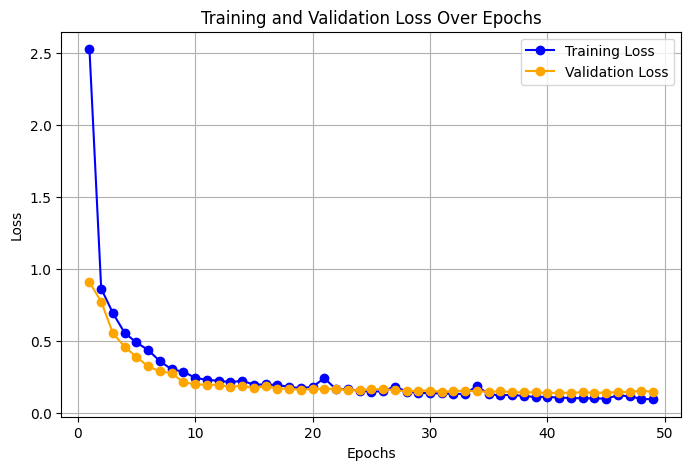

In [ ]:
batch_size = 32
epochs = 100
lr = .001
patience = 10
message_passing_layers = 1


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CASCADE(message_passing_layers, preprocessor)

def learning_rate_step(epoch, learning_rate):
  if epoch % 70 == 0:
    learning_rate = learning_rate*.96
    return learning_rate
  else:
    return learning_rate

train_sequence = RBFSequence(input_data['inputs_train'], y_train, batch_size)
valid_sequence = RBFSequence(input_data['inputs_valid'], y_val, batch_size)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.00001)

train_loss, train_diff, val_loss, val_diff = model.train_self(train_sequence, valid_sequence, criterion, optimizer, scheduler, epochs, patience, device)

file_path = "/content/drive/MyDrive/CSC461/results/"  # Path to the results file

dt = datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")
plt_path = file_path + dt + "loss_plot.png"

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss", marker='o', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation Loss", marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.savefig(plt_path)

MSEloss, abs_loss = model.test(valid_sequence, criterion, device)

print(f"Valid Loss: {MSEloss}")
print(f"Valid Difference: {abs_loss}")
save_training_results(file_path, train_loss, val_loss, MSEloss, abs_loss)

model_path = file_path + dt + "model.pth"
best_model = torch.load('/content/best_model.pth')

## Print and save graph from last training

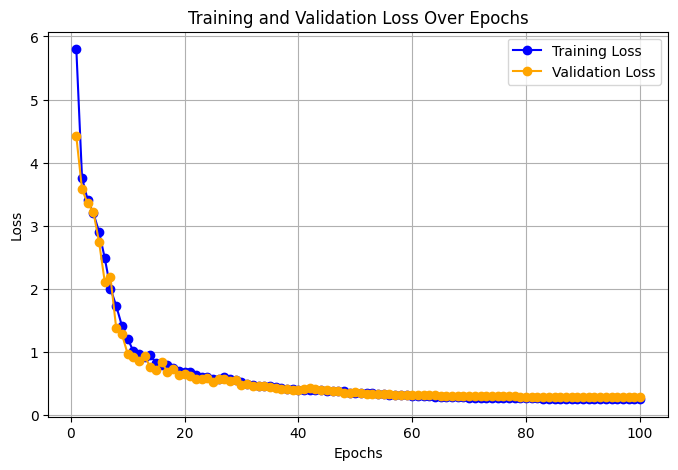

In [ ]:
dt = datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")
path = "/content/drive/MyDrive/CSC461/results/" + dt + "loss_plot.png"

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss", marker='o', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation Loss", marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.savefig(path)


In [ ]:
len(train_sequence)

202

## Save model from last training

In [ ]:
dt = datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")
path = "/content/drive/MyDrive/CSC461/results/" + dt + "loss_plot.png"
model_path = "/content/drive/MyDrive/CSC461/results/" + dt + "model.pth"
best_model = torch.load('/content/best_model.pth')
torch.save( best_model, model_path)

<ipython-input-26-e207ca30a0aa>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('/content/best_model.pth')
